# TabKAN


## Imports & Data Loading

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from scipy.stats import ks_2samp
from imblearn.over_sampling import RandomOverSampler

from tabkan import ChebyshevKAN

# Configuration
RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

# Set seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

✅ Using device: cuda


## Load and Clean Data

In [2]:
# --- LOAD DATA ---
DATA_DIR = os.path.join(os.getcwd(), 'data')

def load_first_csv(data_dir):
    if not os.path.exists(data_dir):
        # Create dummy data if folder missing (Safety fallback)
        print("⚠️ No data folder found. Generating DUMMY data for testing...")
        from sklearn.datasets import make_classification
        X, y = make_classification(n_samples=1000, n_features=10, random_state=42)
        df = pd.DataFrame(X, columns=[f'col_{i}' for i in range(10)])
        df['Churn'] = y
        df['TotalCharges'] = np.random.uniform(10, 1000, 1000)
        return df

    csvs = glob.glob(os.path.join(data_dir, '*.csv'))
    if not csvs:
        raise FileNotFoundError("No CSV files found in /data")
    
    print(f"📂 Loading: {csvs[0]}")
    return pd.read_csv(csvs[0])

df_raw = load_first_csv(DATA_DIR)

# --- CLEANING ---
df = df_raw.copy()
target_col = "Churn"

# 1. Fix Target to 0/1
if df[target_col].dtype == 'O':
    df[target_col] = df[target_col].str.lower().map(
        {'yes':1,'sim':1,'true':1,'no':0,'nao':0,'false':0}
    ).fillna(0)

# 2. Fix TotalCharges (Object -> Float)
if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == 'O':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 3. Drop NaNs
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

# 4. Split X / y
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print(f"✅ Data Loaded. Shape: {df.shape}")

📂 Loading: /home/pcgr/Code/churn-predict/data/customer_churn_telecom_services.csv
✅ Data Loaded. Shape: (7032, 20)


## Pre Processamento
KANs fail if inputs are large integers. We must use StandardScaler to normalize everything to roughly -1 to 1.

In [3]:
# --- PREPROCESSING ---
# KANs need numbers. We OneHotEncode categories and Scale numbers.
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

# Define Transformation Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# Apply Transformations
X_processed = preprocessor.fit_transform(X)
y_processed = y.values

# Split Train/Val/Test (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y_processed, test_size=0.4, random_state=RANDOM_STATE, stratify=y_processed
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

# Oversample Training Data Only
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# --- CONVERT TO PYTORCH TENSORS ---
X_train_t = torch.FloatTensor(X_train_bal).to(DEVICE)
y_train_t = torch.FloatTensor(y_train_bal).unsqueeze(1).to(DEVICE)

X_val_t = torch.FloatTensor(X_val).to(DEVICE)
y_val_t = torch.FloatTensor(y_val).unsqueeze(1).to(DEVICE)

X_test_t = torch.FloatTensor(X_test).to(DEVICE)
y_test_t = torch.FloatTensor(y_test).unsqueeze(1).to(DEVICE)

print(f"✅ Data converted to Tensors.")
print(f"   Input Features: {X_train_t.shape[1]}")
print(f"   Train Size: {X_train_t.shape[0]}")

✅ Data converted to Tensors.
   Input Features: 45
   Train Size: 6196


## Arquitetura do Modelo


In [4]:
import torch
import torch.nn as nn
# Certifique-se de importar a 'Layer' e não o modelo completo
try:
    from tabkan.chebyshev import ChebyKANLayer
except ImportError:
    # Fallback caso a estrutura da library seja diferente, baseado no seu traceback
    from tabkan.chebyshev.model import ChebyKANLayer

class ChurnKAN(nn.Module):
    def __init__(self, input_dim):
        super(ChurnKAN, self).__init__()
        
        # --- CORREÇÃO AQUI ---
        # Usamos ChebyKANLayer(input, output, degree)
        self.layer1 = ChebyKANLayer(input_dim, 32, degree=4)
        self.ln1 = nn.LayerNorm(32)
        
        # Assumindo que você quer uma saída final de 1 neurônio (Binary Classification)
        # Se sua rede tinha mais camadas, adicione-as aqui da mesma forma
        self.layer2 = ChebyKANLayer(32, 1, degree=4) 
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.ln1(x)
        x = torch.tanh(x) # KANs costumam performar bem com tanh ou silu no meio
        x = self.layer2(x)
        return x

In [5]:
# Initialize Model
input_dim = X_train_t.shape[1]

# Agora isso deve funcionar sem o erro de TypeError
model = ChurnKAN(input_dim).to(DEVICE)

# Optimizer & Loss
criterion = nn.BCEWithLogitsLoss()
# Adicionei o otimizador caso precise rodar logo em seguida
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

print("Modelo inicializado com sucesso:")
print(model)

Modelo inicializado com sucesso:
ChurnKAN(
  (layer1): ChebyKANLayer()
  (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (layer2): ChebyKANLayer()
)


## Training

In [6]:
# Configurações de Treino
epochs = 1000  # Ajuste conforme necessário
print_every = 100
train_losses = []

print("Iniciando treinamento...")

for epoch in range(epochs):
    model.train()
    
    # 1. Forward pass
    optimizer.zero_grad()
    outputs = model(X_train_t)
    
    # Ajuste de dimensão do target se necessário (de [N] para [N, 1])
    # O BCEWithLogitsLoss espera que output e target tenham o mesmo shape
    loss = criterion(outputs, y_train_t.view(-1, 1))
    
    # 2. Backward pass e Otimização
    loss.backward()
    optimizer.step()
    
    # Guardar histórico
    train_losses.append(loss.item())
    
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.4f}')

print("Treinamento finalizado.")

Iniciando treinamento...
Epoch [100/1000] | Loss: 0.4144
Epoch [200/1000] | Loss: 0.3461
Epoch [300/1000] | Loss: 0.2986
Epoch [400/1000] | Loss: 0.2620
Epoch [500/1000] | Loss: 0.2316
Epoch [600/1000] | Loss: 0.2100
Epoch [700/1000] | Loss: 0.1936
Epoch [800/1000] | Loss: 0.1783
Epoch [900/1000] | Loss: 0.1670
Epoch [1000/1000] | Loss: 0.1575
Treinamento finalizado.


## Plot & Evaluation

Acurácia no Teste: 75.69%
KS Statistic: 0.4600

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.83      1033
         1.0       0.54      0.62      0.58       374

    accuracy                           0.76      1407
   macro avg       0.70      0.71      0.70      1407
weighted avg       0.77      0.76      0.76      1407



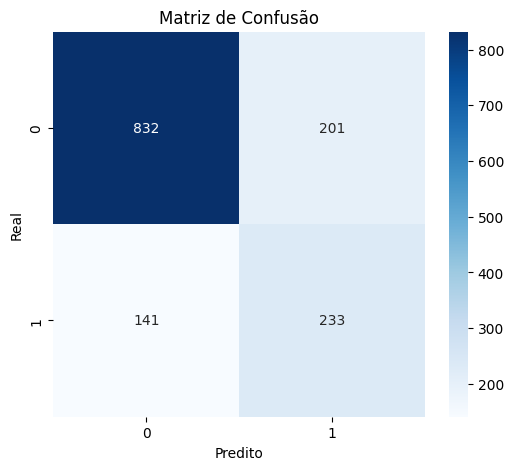

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
with torch.no_grad():
    # 1. Obter previsões (Logits)
    y_logits = model(X_test_t)
    
    # 2. Converter para probabilidade (Sigmoid) e depois para Classe (0 ou 1)
    y_probs = torch.sigmoid(y_logits)
    y_preds = (y_probs > 0.5).float()
    
    # 3. Mover para CPU para usar com Scikit-Learn
    y_preds_np = y_preds.cpu().numpy()
    y_test_np = y_test_t.cpu().numpy()

# Calcular métricas
acc = accuracy_score(y_test_np, y_preds_np)

# Calcular KS
# Precisamos separar as probabilidades para classe 0 e classe 1
class0_probs = y_probs[y_test_t.view(-1) == 0].cpu().numpy().flatten()
class1_probs = y_probs[y_test_t.view(-1) == 1].cpu().numpy().flatten()

if len(class0_probs) > 0 and len(class1_probs) > 0:
    ks_stat = ks_2samp(class1_probs, class0_probs).statistic
else:
    ks_stat = 0.0

print(f'Acurácia no Teste: {acc:.2%}')
print(f'KS Statistic: {ks_stat:.4f}') # Adicionado KS aqui
print("\nRelatório de Classificação:")
print(classification_report(y_test_np, y_preds_np))

# (Opcional) Plotar Matriz de Confusão
cm = confusion_matrix(y_test_np, y_preds_np)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

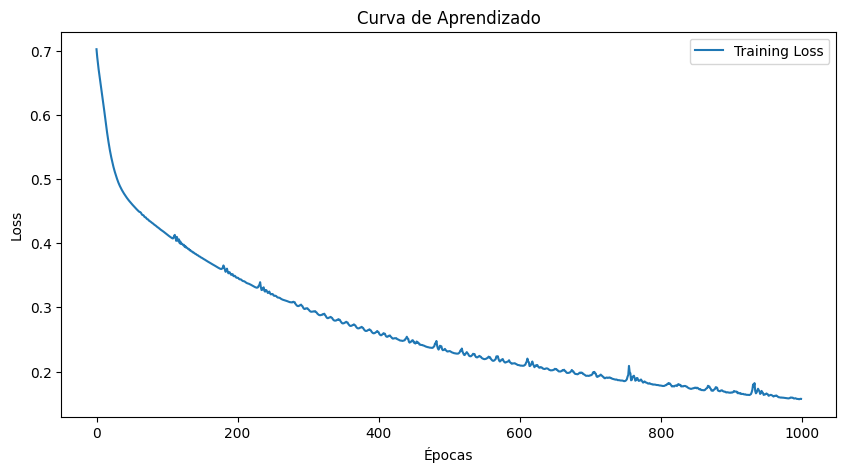

In [8]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.title('Curva de Aprendizado')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

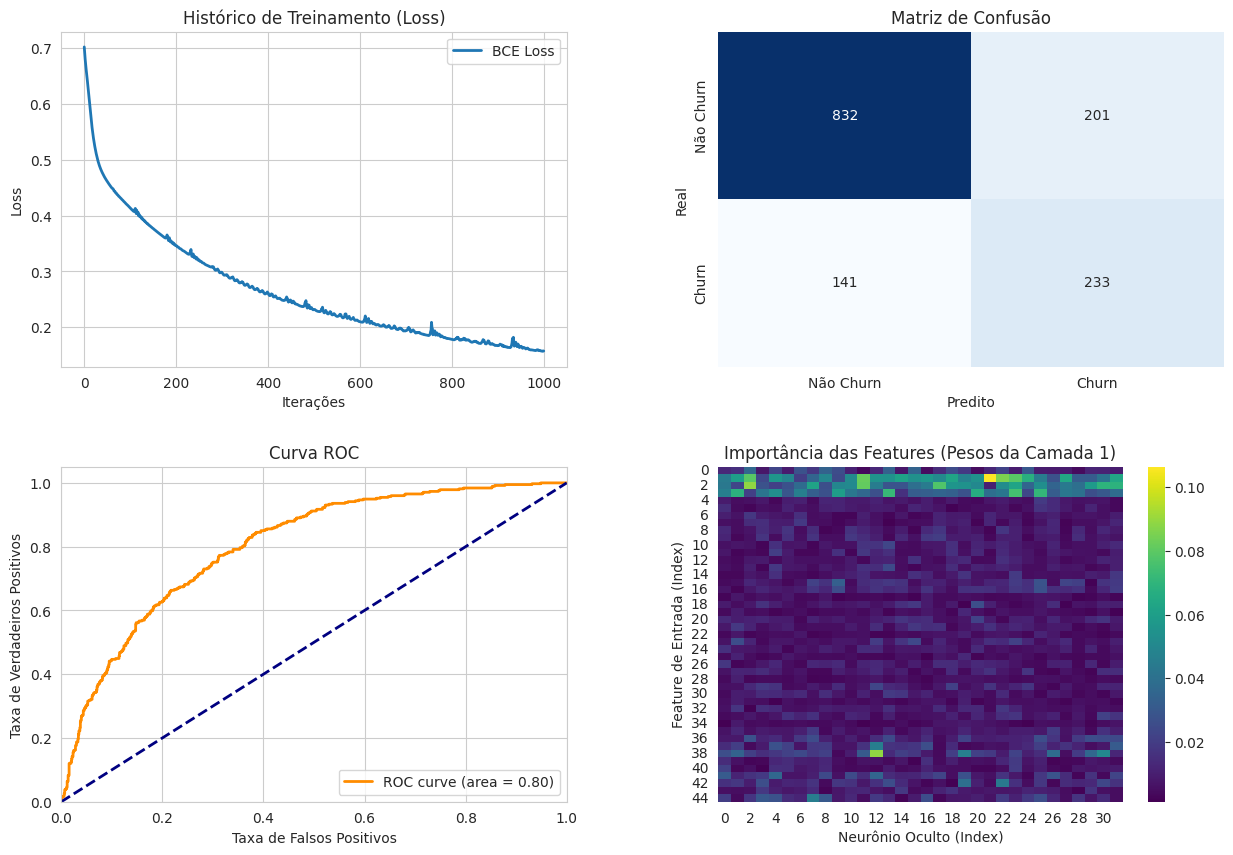

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import torch

def plot_churn_kan_results(model, train_losses, X_test, y_test):
    """
    Script completo para visualizar treinamento, performance e pesos da KAN.
    """
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 10})
    
    # Configurar layout do grid (2 linhas, 2 colunas)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # ------------------------------------------
    # 1. Curva de Loss (Treinamento)
    # ------------------------------------------
    ax1 = axes[0, 0]
    ax1.plot(train_losses, label='BCE Loss', color='tab:blue', linewidth=2)
    ax1.set_title('Histórico de Treinamento (Loss)')
    ax1.set_xlabel('Iterações')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # ------------------------------------------
    # Preparar Previsões
    # ------------------------------------------
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_true = y_test.cpu().numpy()

    # ------------------------------------------
    # 2. Matriz de Confusão
    # ------------------------------------------
    ax2 = axes[0, 1]
    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False)
    ax2.set_title('Matriz de Confusão')
    ax2.set_xlabel('Predito')
    ax2.set_ylabel('Real')
    ax2.set_xticklabels(['Não Churn', 'Churn'])
    ax2.set_yticklabels(['Não Churn', 'Churn'])

    # ------------------------------------------
    # 3. Curva ROC
    # ------------------------------------------
    ax3 = axes[1, 0]
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('Taxa de Falsos Positivos')
    ax3.set_ylabel('Taxa de Verdadeiros Positivos')
    ax3.set_title('Curva ROC')
    ax3.legend(loc="lower right")

    # ------------------------------------------
    # 4. Visualização dos Pesos KAN (Feature Importance)
    # ------------------------------------------
    # Tentamos extrair os coeficientes da primeira camada
    # Na maioria das implementações KAN, os pesos são (in_features, out_features, degree)
    # Vamos calcular a norma média desses pesos para ver a "força" da conexão
    ax4 = axes[1, 1]
    try:
        # Acessa os parâmetros da layer1
        # Nota: O nome exato do parâmetro varia, mas geralmente é o primeiro listado
        layer1_weights = list(model.layer1.parameters())[0].data.cpu().numpy()
        
        # Se for 3D (in, out, degree), tiramos a média absoluta para simplificar em 2D
        if len(layer1_weights.shape) == 3:
            # Heatmap: Eixo X = Neurônios Ocultos, Eixo Y = Features de Entrada
            weight_magnitude = np.mean(np.abs(layer1_weights), axis=2)
            
            sns.heatmap(weight_magnitude, cmap='viridis', ax=ax4)
            ax4.set_title('Importância das Features (Pesos da Camada 1)')
            ax4.set_ylabel('Feature de Entrada (Index)')
            ax4.set_xlabel('Neurônio Oculto (Index)')
        else:
            ax4.text(0.5, 0.5, "Formato de pesos não suportado para plot 2D", ha='center')
            
    except Exception as e:
        ax4.text(0.5, 0.5, f"Não foi possível visualizar pesos:\n{str(e)}", ha='center')
        ax4.axis('off')

    plt.show()

# --- Executar o Script ---
# Certifique-se de que train_losses foi preenchido na célula anterior
if 'train_losses' in locals() and len(train_losses) > 0:
    plot_churn_kan_results(model, train_losses, X_test_t, y_test_t)
else:
    print("A variável 'train_losses' está vazia. Rode o treinamento primeiro.")

# Optuna Optimization

In [10]:
import optuna
import torch.nn as nn
import torch.optim as optim

/home/pcgr/Code/churn-predict/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
class ChurnKAN_Optuna(nn.Module):
    def __init__(self, input_dim, hidden_dim, degree):
        super(ChurnKAN_Optuna, self).__init__()
        
        # Camada 1: Dimensão e Grau dinâmicos
        self.layer1 = ChebyKANLayer(input_dim, hidden_dim, degree=degree)
        self.ln1 = nn.LayerNorm(hidden_dim)
        
        # Camada 2: Saída
        self.layer2 = ChebyKANLayer(hidden_dim, 1, degree=degree)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.ln1(x)
        x = torch.tanh(x) 
        x = self.layer2(x)
        return x

In [12]:
def objective(trial):
    # --- 1. Sugestão de Hiperparâmetros ---
    hidden_dim = trial.suggest_int('hidden_dim', 16, 64)   # Neurônios na oculta
    degree = trial.suggest_int('degree', 2, 5)             # Grau do polinômio
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)   # Learning Rate
    
    # --- 2. Setup do Modelo ---
    model = ChurnKAN_Optuna(input_dim, hidden_dim, degree).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    
    # --- 3. Loop de Treino Rápido (com Pruning) ---
    # Usamos menos épocas no Optuna para ser rápido (ex: 50 ou 100)
    # O objetivo é descobrir qual config aprende melhor, não treinar até o final
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        # --- 4. Validação e Pruning ---
        model.eval()
        with torch.no_grad():
            logits = model(X_test_t)
            y_probs = torch.sigmoid(logits)
            y_preds = (y_probs > 0.5).float()
            
            # Métrica para otimizar: Acurácia
            accuracy = (y_preds.eq(y_test_t.view(-1, 1))).sum().item() / y_test_t.shape[0]
            
        # Reportar ao Optuna (para ele saber se o treino está indo bem)
        trial.report(accuracy, epoch)

        # Handle pruning (para testes ruins no meio do caminho)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return accuracy

In [13]:
# Criar o estudo (Maximizando a acurácia)
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

print("Iniciando otimização com Optuna...")
# n_trials = quantas combinações diferentes ele vai tentar
study.optimize(objective, n_trials=20) 

print("\n------------------------------------------------")
print("Melhores parâmetros encontrados:")
print(study.best_params)
print(f"Melhor Acurácia: {study.best_value:.4f}")
print("------------------------------------------------")

[I 2025-12-19 10:29:45,424] A new study created in memory with name: no-name-5d59e318-dfaf-44c5-bd2f-d15d21c5d3e8
[I 2025-12-19 10:29:45,498] Trial 0 finished with value: 0.7306325515280739 and parameters: {'hidden_dim': 35, 'degree': 4, 'lr': 0.0003038647027374487}. Best is trial 0 with value: 0.7306325515280739.
[I 2025-12-19 10:29:45,556] Trial 1 finished with value: 0.7327647476901208 and parameters: {'hidden_dim': 20, 'degree': 2, 'lr': 0.000118902157983718}. Best is trial 1 with value: 0.7327647476901208.
[I 2025-12-19 10:29:45,612] Trial 2 finished with value: 0.7370291400142146 and parameters: {'hidden_dim': 61, 'degree': 3, 'lr': 0.001472231112882607}. Best is trial 2 with value: 0.7370291400142146.


Iniciando otimização com Optuna...


[I 2025-12-19 10:29:45,673] Trial 3 finished with value: 0.7334754797441365 and parameters: {'hidden_dim': 38, 'degree': 4, 'lr': 0.00021093541760604812}. Best is trial 2 with value: 0.7370291400142146.
[I 2025-12-19 10:29:45,740] Trial 4 finished with value: 0.7398720682302772 and parameters: {'hidden_dim': 23, 'degree': 5, 'lr': 0.0036116672864035947}. Best is trial 4 with value: 0.7398720682302772.
[I 2025-12-19 10:29:45,742] Trial 5 pruned. 
[I 2025-12-19 10:29:45,799] Trial 6 finished with value: 0.7412935323383084 and parameters: {'hidden_dim': 64, 'degree': 3, 'lr': 0.000127034537100954}. Best is trial 6 with value: 0.7412935323383084.
[I 2025-12-19 10:29:45,801] Trial 7 pruned. 
[I 2025-12-19 10:29:45,803] Trial 8 pruned. 
[I 2025-12-19 10:29:45,812] Trial 9 pruned. 
[I 2025-12-19 10:29:45,870] Trial 10 finished with value: 0.7348969438521677 and parameters: {'hidden_dim': 64, 'degree': 2, 'lr': 0.006657623710722788}. Best is trial 6 with value: 0.7412935323383084.
[I 2025-12-1


------------------------------------------------
Melhores parâmetros encontrados:
{'hidden_dim': 28, 'degree': 3, 'lr': 0.00999384294143953}
Melhor Acurácia: 0.7477
------------------------------------------------


In [14]:
# 1. Pegar melhores params
best_params = study.best_params

# 2. Instanciar modelo vencedor
best_model = ChurnKAN_Optuna(
    input_dim, 
    best_params['hidden_dim'], 
    best_params['degree']
).to(DEVICE)

# 3. Treinar (agora com mais épocas, ex: 500 ou 1000)
optimizer = optim.AdamW(best_model.parameters(), lr=best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

print(f"Treinando modelo final com: {best_params}")

train_losses = []
for epoch in range(500): # Mais épocas para o modelo final
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(X_train_t)
    loss = criterion(outputs, y_train_t.view(-1, 1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

# 4. Plotar Resultados
from sklearn.metrics import accuracy_score

Treinando modelo final com: {'hidden_dim': 28, 'degree': 3, 'lr': 0.00999384294143953}


## Plot and Evaluation

RELATÓRIO DE PERFORMANCE (KAN OPTIMIZED)
              precision    recall  f1-score   support

   Não Churn       0.86      0.77      0.81      1033
       Churn       0.50      0.64      0.56       374

    accuracy                           0.73      1407
   macro avg       0.68      0.70      0.68      1407
weighted avg       0.76      0.73      0.74      1407

KS Statistic: 0.4334


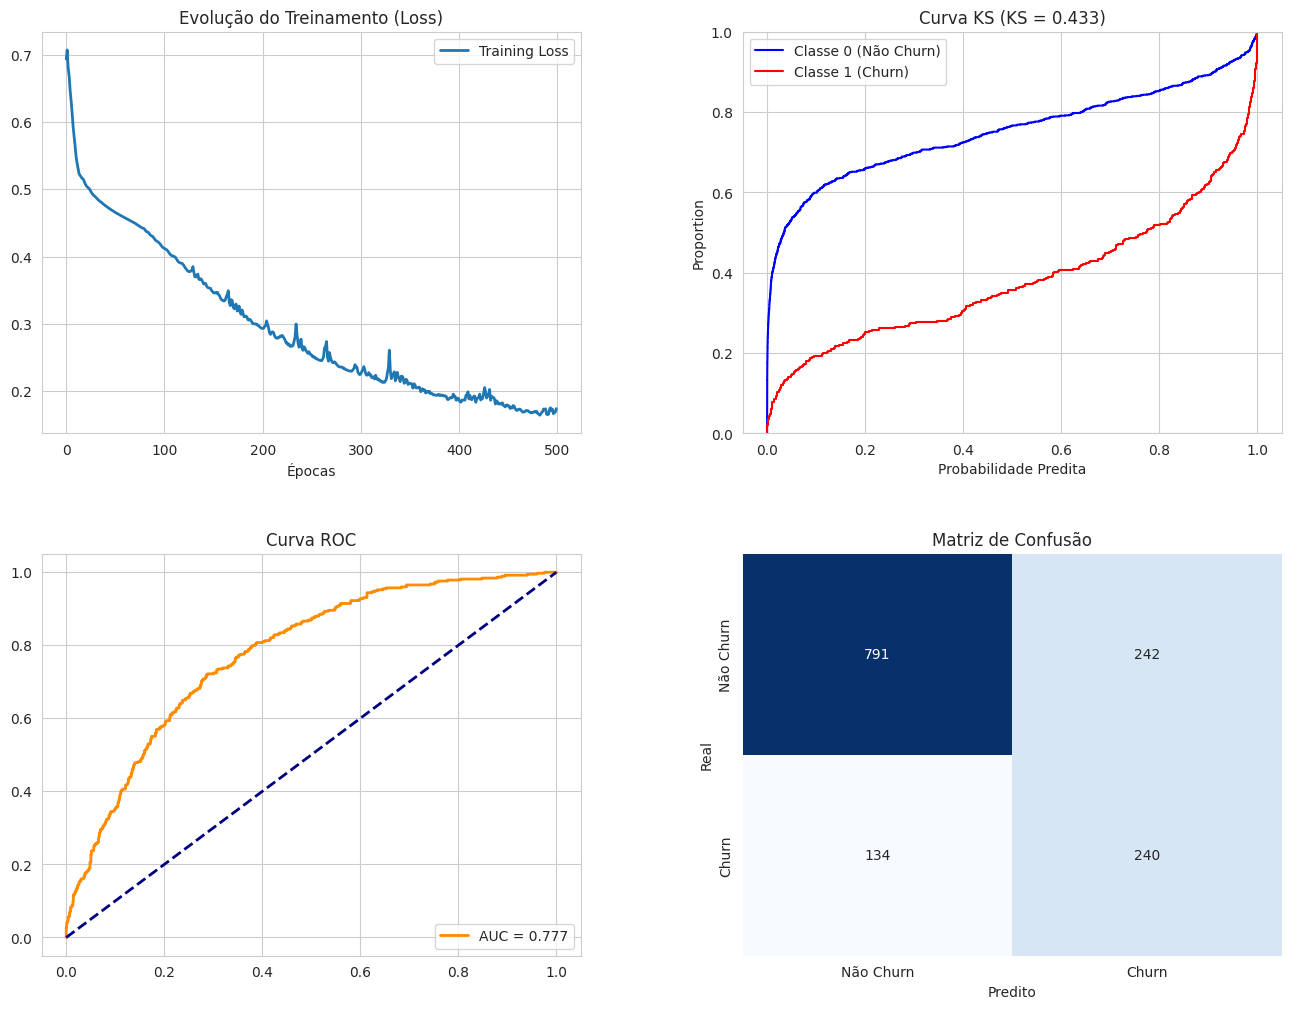

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from scipy.stats import ks_2samp
import numpy as np
import torch

def plot_complete_metrics(model, train_losses, X_test, y_test):
    # 1. Preparar dados (Forward Pass)
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        
        # Achata 'probs' para 1D (N,)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        
        preds = (probs > 0.5).astype(int)
        
        # --- CORREÇÃO AQUI ---
        # Achata 'y_true' também para garantir que seja 1D (N,) e não (N, 1)
        y_true = y_test.cpu().numpy().flatten()

    # ------------------------------------------
    # PARTE 1: Métricas de Texto (F1, Acurácia)
    # ------------------------------------------
    print("="*60)
    print("RELATÓRIO DE PERFORMANCE (KAN OPTIMIZED)")
    print("="*60)
    
    # Classification Report
    print(classification_report(y_true, preds, target_names=['Não Churn', 'Churn']))
    
    # Cálculo do KS Statistic
    # Agora ambos são 1D, então a indexação booleana funciona
    class0_probs = probs[y_true == 0]
    class1_probs = probs[y_true == 1]
    
    if len(class0_probs) > 0 and len(class1_probs) > 0:
        ks_stat = ks_2samp(class1_probs, class0_probs).statistic
        print(f"KS Statistic: {ks_stat:.4f}")
    else:
        ks_stat = 0.0
        print("KS Statistic: N/A (Classes desbalanceadas ou vazias)")
        
    print("="*60)

    # ------------------------------------------
    # PARTE 2: Gráficos
    # ------------------------------------------
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Gráfico 1: Loss
    ax1 = axes[0, 0]
    ax1.plot(train_losses, label='Training Loss', color='tab:blue', lw=2)
    ax1.set_title('Evolução do Treinamento (Loss)')
    ax1.set_xlabel('Épocas')
    ax1.legend()

    # Gráfico 2: KS Plot
    ax2 = axes[0, 1]
    sns.ecdfplot(class0_probs, label='Classe 0 (Não Churn)', ax=ax2, color='blue')
    sns.ecdfplot(class1_probs, label='Classe 1 (Churn)', ax=ax2, color='red')
    ax2.set_title(f'Curva KS (KS = {ks_stat:.3f})')
    ax2.legend()
    ax2.set_xlabel('Probabilidade Predita')

    # Gráfico 3: ROC
    ax3 = axes[1, 0]
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax3.set_title('Curva ROC')
    ax3.legend(loc="lower right")

    # Gráfico 4: Matriz de Confusão
    ax4 = axes[1, 1]
    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, cbar=False)
    ax4.set_title('Matriz de Confusão')
    ax4.set_xlabel('Predito')
    ax4.set_ylabel('Real')
    ax4.set_xticklabels(['Não Churn', 'Churn'])
    ax4.set_yticklabels(['Não Churn', 'Churn'])

    plt.show()

# --- Executar ---
if 'best_model' in locals() and 'train_losses' in locals():
    plot_complete_metrics(best_model, train_losses, X_test_t, y_test_t)

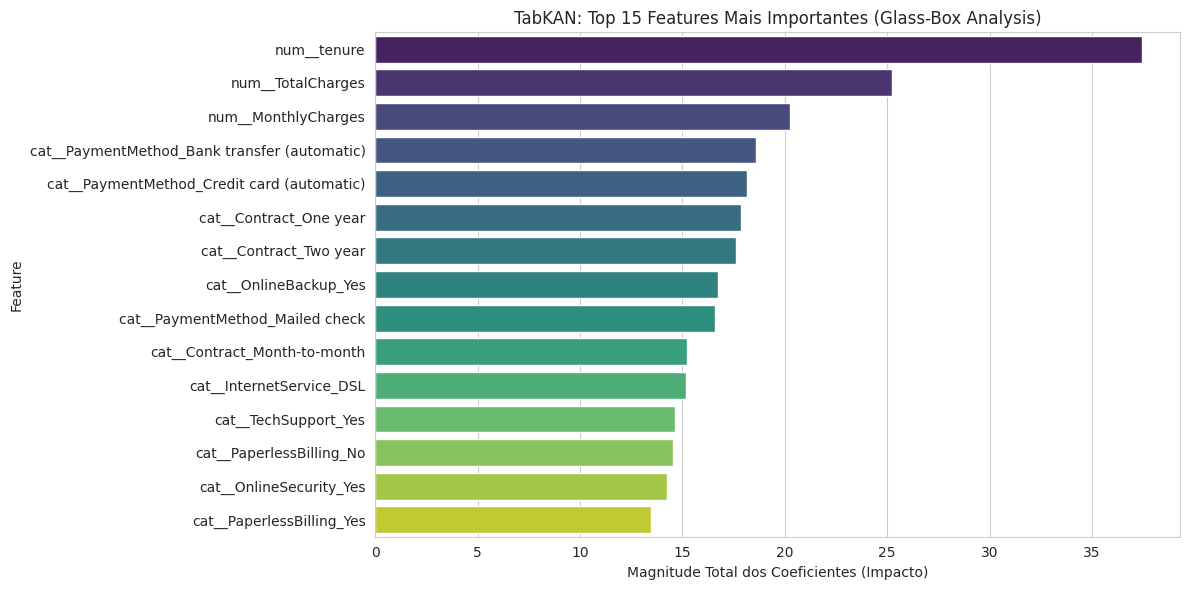

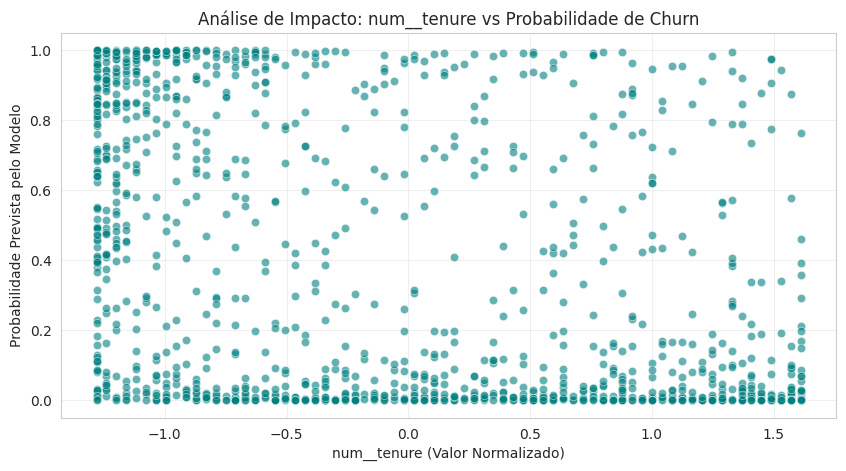

In [16]:
# ...existing code...
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# --- INTERPRETABILIDADE GLASS-BOX ---

# 1. Recuperar nomes das features do Preprocessor
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback para versões antigas do scikit-learn
    feature_names = [f"Feat_{i}" for i in range(X_test_t.shape[1])]

# 2. Extrair Importância Global dos Pesos da Camada 1
# A estrutura de pesos do TabKAN geralmente é (in_features, out_features, degree)
# Somamos a magnitude absoluta de todos os coeficientes para cada feature de entrada
layer1_weights = list(best_model.layer1.parameters())[0].data.cpu().numpy()

if len(layer1_weights.shape) == 3:
    # Soma sobre neurônios de saída (axis 1) e graus do polinômio (axis 2)
    importances = np.sum(np.abs(layer1_weights), axis=(1, 2))
else:
    # Fallback se a estrutura for 2D
    importances = np.sum(np.abs(layer1_weights), axis=1)

# Criar DataFrame para visualização
df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_imp = df_imp.sort_values('importance', ascending=False).head(15)

# 3. Plot 1: Importância das Features (Bar Chart)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_imp, x='importance', y='feature', palette='viridis', hue='feature', legend=False)
plt.title('TabKAN: Top 15 Features Mais Importantes (Glass-Box Analysis)')
plt.xlabel('Magnitude Total dos Coeficientes (Impacto)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 4. Plot 2: Visualizando a "Forma" da Decisão (Top Feature vs Churn)
# Isso mostra a não-linearidade que o KAN aprendeu
top_feature = df_imp.iloc[0]['feature']
top_idx = list(feature_names).index(top_feature)

# Pegar valores reais (normalizados) e predições
X_sample = X_test_t.cpu().numpy()
feature_vals = X_sample[:, top_idx]

best_model.eval()
with torch.no_grad():
    preds = torch.sigmoid(best_model(X_test_t)).cpu().numpy().flatten()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=feature_vals, y=preds, alpha=0.6, color='teal')
plt.title(f'Análise de Impacto: {top_feature} vs Probabilidade de Churn')
plt.xlabel(f'{top_feature} (Valor Normalizado)')
plt.ylabel('Probabilidade Prevista pelo Modelo')
plt.grid(True, alpha=0.3)
plt.show()